# Import Modules

In [1]:
import numpy as np
from fourrooms import Fourrooms
from IPython.display import clear_output
from aoaoc_tabular import *
import matplotlib.pyplot as plt
from visualize import Visualization

# HyperParameters

In [7]:
# Replace the command line argparse
class Arguments:
    def __init__(self):
        # Numbers
        self.nepisodes=5000
        self.nsteps=2000
        self.noptions=2
        
        # Learning Rates
        self.lr_term=0.25
        self.lr_intra=0.25
        self.lr_critic=0.5
        self.lr_criticA=0.5
        self.lr_attend=0.1
        
        # Environment Parameters
        self.discount=0.99
        self.deterministic = False
        self.punishEachStep = True
        self.modified = True
        self.easier = True
        
        self.goalChangeEps = 3000
        
        # Attention Parameters
        self.h_learn = False
        self.normalize = True
               
        # Policy Parameters
        self.epsilon=1e-1
        self.temp=1.
        
        # Objective Parameters
        self.wo1 = 0.1   #q
        self.wo2 = 1.    #cosim
        self.wo3 = 0.    #entropy
        self.wo4 = 0.    #size
        
        # Randomness Parameters
        self.seed=2222
        self.seed_startstate=1111
        
        # Display Parameters
        self.showMap = False
        self.showAttention = False
        self.showOptPref = False
        self.showFrequency = 10
        
        # Other Parameters
        self.baseline=True
        self.dc = 2.
        
        
args = Arguments()

# Run

## Set up

In [8]:
rng = np.random.RandomState(args.seed)
env = Fourrooms(args.seed_startstate, args.punishEachStep, args.deterministic, args.modified, args.easier)

possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

features = Tabular(env.observation_space)
nfeatures, nactions = len(features), env.action_space

viz = Visualization(env, args, nactions)

cumRewRec = np.zeros(args.nepisodes)
stepRec = np.zeros(args.nepisodes)

## Main loop

In [9]:
# Set up classes
policy_over_options = POO(rng, nfeatures, args)
CoSimObj.reset()
options = [Option(rng, nfeatures, nactions, args, policy_over_options, i) for i in range(args.noptions)]

# Loop through games
for episode in range(args.nepisodes):
    # Goal Change
    if episode == args.goalChangeEps:
#         env.goal = int(np.random.uniform(0, env.observation_space))
        env = Fourrooms(args.seed_startstate, args.punishEachStep, args.deterministic, args.modified, False)
        viz = Visualization(env, args, nactions)
    
    # Initial state
    return_per_episode = 0.0
    observation = env.reset()
    phi = features(observation)    
    option = policy_over_options.sample(phi)
    action = options[option].sample(phi)
    traject = [[phi,option],[phi,option],action]
    viz.resetMap(phi)

    # Reset record
    cumreward = 0.
    duration = 1
    option_switches = 0
    avgduration = 0.

    # Loop through frames in 1 game
    for step in range(args.nsteps):
        # Collect feedback from environment
        observation, reward, done, _ = env.step(action)
        phi = features(observation)
        return_per_episode += pow(args.discount,step)*reward

        # Render
        if args.showMap and episode % 100 == 99:
            clear_output(wait=True)
            viz.showMap(phi, option)

        # Store option index
        last_option = option

        # Check termination
        termination = options[option].terminate(phi, value=True)
        if options[option].terminate(phi):
            option = policy_over_options.sample(phi)
            option_switches += 1
            avgduration += (1./option_switches)*(duration - avgduration)
            duration = 1

        # Record into trajectory
        traject[0] = traject[1]
        traject[1] = [phi, option]
        traject[2] = action

        # Sample next action
        action = options[option].sample(phi)

        # Policy Evaluation + Policy Improvement
        baseline = policy_over_options.value(traject[0][0], traject[0][1])
        advantage = policy_over_options.advantage(phi, last_option)
        options[last_option].update(traject, reward, done, phi, last_option, termination, baseline, advantage)
        policy_over_options.update(traject, reward, done, termination)

        # End of frame
        cumreward += reward
        duration += 1
        if done:
            break

    # Attention graph
    if episode % args.showFrequency == 0:
        if args.showAttention:
            clear_output(wait=True)
            viz.showAttention(options)
            print(options[0].policy.attention.weights)
        if args.showOptPref:
            clear_output(wait=True)
            viz.showPref(policy_over_options.weights)
    cumRewRec[episode] = cumreward
    stepRec[episode] = step
    print('Episode {} steps {} cumreward {} avg. duration {} switches {}'.format(episode, step, cumreward, avgduration, option_switches))

Episode 0 steps 521 cumreward -992.0 avg. duration 3.407407407407407 switches 216
Episode 1 steps 855 cumreward -1660.0 avg. duration 3.4782608695652186 switches 345
Episode 2 steps 6 cumreward 38.0 avg. duration 2.5 switches 4
Episode 3 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Episode 4 steps 844 cumreward -1638.0 avg. duration 4.13382899628253 switches 269
Episode 5 steps 199 cumreward -348.0 avg. duration 4.482142857142857 switches 56
Episode 6 steps 182 cumreward -314.0 avg. duration 5.1363636363636385 switches 44
Episode 7 steps 761 cumreward -1472.0 avg. duration 4.470319634703196 switches 219
Episode 8 steps 327 cumreward -604.0 avg. duration 6.109374999999999 switches 64
Episode 9 steps 415 cumreward -780.0 avg. duration 6.421052631578947 switches 76
Episode 10 steps 87 cumreward -124.0 avg. duration 4.954545454545455 switches 22
Episode 11 steps 571 cumreward -1092.0 avg. duration 6.533980582524273 switches 103
Episode 12 steps 518 cumreward -986.0 avg. duration 6.8

Episode 125 steps 62 cumreward -74.0 avg. duration 3.761904761904762 switches 21
Episode 126 steps 29 cumreward -8.0 avg. duration 4.125 switches 8
Episode 127 steps 23 cumreward 4.0 avg. duration 4.142857142857143 switches 7
Episode 128 steps 10 cumreward 30.0 avg. duration 3.0 switches 3
Episode 129 steps 6 cumreward 38.0 avg. duration 3.0 switches 1
Episode 130 steps 17 cumreward 16.0 avg. duration 3.6 switches 5
Episode 131 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 132 steps 165 cumreward -280.0 avg. duration 9.631578947368421 switches 19
Episode 133 steps 23 cumreward 4.0 avg. duration 3.8571428571428577 switches 7
Episode 134 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 135 steps 18 cumreward 14.0 avg. duration 6.666666666666667 switches 3
Episode 136 steps 38 cumreward -26.0 avg. duration 8.4 switches 5
Episode 137 steps 15 cumreward 20.0 avg. duration 2.75 switches 8
Episode 138 steps 22 cumreward 6.0 avg. duration 5.5 switches 4
Episode 139 ste

Episode 254 steps 23 cumreward 4.0 avg. duration 3.111111111111111 switches 9
Episode 255 steps 29 cumreward -8.0 avg. duration 3.8888888888888897 switches 9
Episode 256 steps 7 cumreward 36.0 avg. duration 2.5 switches 4
Episode 257 steps 23 cumreward 4.0 avg. duration 4.8 switches 5
Episode 258 steps 13 cumreward 24.0 avg. duration 2.4285714285714284 switches 7
Episode 259 steps 40 cumreward -30.0 avg. duration 5.75 switches 8
Episode 260 steps 7 cumreward 36.0 avg. duration 2.5 switches 4
Episode 261 steps 8 cumreward 34.0 avg. duration 2.0 switches 3
Episode 262 steps 20 cumreward 10.0 avg. duration 3.375 switches 8
Episode 263 steps 7 cumreward 36.0 avg. duration 3.0 switches 3
Episode 264 steps 7 cumreward 36.0 avg. duration 2.0 switches 2
Episode 265 steps 26 cumreward -2.0 avg. duration 3.8749999999999996 switches 8
Episode 266 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 267 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Episode 268 steps 6 cumreward 38.0 a

Episode 374 steps 18 cumreward 14.0 avg. duration 3.8333333333333335 switches 6
Episode 375 steps 24 cumreward 2.0 avg. duration 5.6 switches 5
Episode 376 steps 23 cumreward 4.0 avg. duration 3.375 switches 8
Episode 377 steps 19 cumreward 12.0 avg. duration 5.5 switches 4
Episode 378 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Episode 379 steps 25 cumreward 0.0 avg. duration 3.1 switches 10
Episode 380 steps 10 cumreward 30.0 avg. duration 2.75 switches 4
Episode 381 steps 7 cumreward 36.0 avg. duration 2.5 switches 4
Episode 382 steps 4 cumreward 42.0 avg. duration 1.0 switches 1
Episode 383 steps 7 cumreward 36.0 avg. duration 2.5 switches 4
Episode 384 steps 13 cumreward 24.0 avg. duration 7.0 switches 2
Episode 385 steps 29 cumreward -8.0 avg. duration 15.0 switches 2
Episode 386 steps 23 cumreward 4.0 avg. duration 3.75 switches 8
Episode 387 steps 19 cumreward 12.0 avg. duration 4.0 switches 6
Episode 388 steps 7 cumreward 36.0 avg. duration 3.5 switches 2
Episode 389 s

Episode 499 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Episode 500 steps 28 cumreward -6.0 avg. duration 4.0 switches 9
Episode 501 steps 6 cumreward 38.0 avg. duration 2.6666666666666665 switches 3
Episode 502 steps 14 cumreward 22.0 avg. duration 3.0 switches 5
Episode 503 steps 22 cumreward 6.0 avg. duration 11.5 switches 2
Episode 504 steps 7 cumreward 36.0 avg. duration 3.5 switches 2
Episode 505 steps 5 cumreward 40.0 avg. duration 1.5 switches 2
Episode 506 steps 18 cumreward 14.0 avg. duration 6.666666666666667 switches 3
Episode 507 steps 4 cumreward 42.0 avg. duration 1.75 switches 4
Episode 508 steps 6 cumreward 38.0 avg. duration 2.5 switches 2
Episode 509 steps 4 cumreward 42.0 avg. duration 1.0 switches 1
Episode 510 steps 19 cumreward 12.0 avg. duration 3.833333333333333 switches 6
Episode 511 steps 9 cumreward 32.0 avg. duration 5.0 switches 2
Episode 512 steps 22 cumreward 6.0 avg. duration 3.0 switches 4
Episode 513 steps 4 cumreward 42.0 avg. duration 2.5 sw

Episode 618 steps 33 cumreward -16.0 avg. duration 2.6842105263157894 switches 19
Episode 619 steps 23 cumreward 4.0 avg. duration 6.25 switches 4
Episode 620 steps 19 cumreward 12.0 avg. duration 5.0 switches 4
Episode 621 steps 27 cumreward -4.0 avg. duration 3.083333333333333 switches 12
Episode 622 steps 29 cumreward -8.0 avg. duration 14.5 switches 2
Episode 623 steps 14 cumreward 22.0 avg. duration 5.333333333333334 switches 3
Episode 624 steps 15 cumreward 20.0 avg. duration 2.75 switches 8
Episode 625 steps 27 cumreward -4.0 avg. duration 6.0 switches 5
Episode 626 steps 8 cumreward 34.0 avg. duration 3.0 switches 3
Episode 627 steps 32 cumreward -14.0 avg. duration 5.428571428571429 switches 7
Episode 628 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Episode 629 steps 25 cumreward 0.0 avg. duration 13.0 switches 2
Episode 630 steps 17 cumreward 16.0 avg. duration 3.3333333333333335 switches 6
Episode 631 steps 10 cumreward 30.0 avg. duration 5.5 switches 2
Episode 632 st

Episode 743 steps 25 cumreward 0.0 avg. duration 6.75 switches 4
Episode 744 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 745 steps 13 cumreward 24.0 avg. duration 3.25 switches 4
Episode 746 steps 4 cumreward 42.0 avg. duration 2.0 switches 2
Episode 747 steps 19 cumreward 12.0 avg. duration 2.888888888888889 switches 9
Episode 748 steps 2 cumreward 46.0 avg. duration 0.0 switches 0
Episode 749 steps 4 cumreward 42.0 avg. duration 2.0 switches 3
Episode 750 steps 27 cumreward -4.0 avg. duration 3.2222222222222223 switches 9
Episode 751 steps 17 cumreward 16.0 avg. duration 9.0 switches 2
Episode 752 steps 6 cumreward 38.0 avg. duration 3.5 switches 2
Episode 753 steps 18 cumreward 14.0 avg. duration 4.75 switches 4
Episode 754 steps 28 cumreward -6.0 avg. duration 2.923076923076923 switches 13
Episode 755 steps 25 cumreward 0.0 avg. duration 2.833333333333333 switches 12
Episode 756 steps 3 cumreward 44.0 avg. duration 1.5 switches 2
Episode 757 steps 9 cumreward 32.0 a

Episode 870 steps 26 cumreward -2.0 avg. duration 5.166666666666666 switches 6
Episode 871 steps 2 cumreward 46.0 avg. duration 1.0 switches 1
Episode 872 steps 18 cumreward 14.0 avg. duration 6.333333333333334 switches 3
Episode 873 steps 52 cumreward -54.0 avg. duration 3.611111111111111 switches 18
Episode 874 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Episode 875 steps 25 cumreward 0.0 avg. duration 2.2777777777777777 switches 18
Episode 876 steps 5 cumreward 40.0 avg. duration 2.5 switches 2
Episode 877 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Episode 878 steps 12 cumreward 26.0 avg. duration 11.0 switches 1
Episode 879 steps 19 cumreward 12.0 avg. duration 4.2 switches 5
Episode 880 steps 8 cumreward 34.0 avg. duration 2.2 switches 5
Episode 881 steps 17 cumreward 16.0 avg. duration 5.0 switches 4
Episode 882 steps 18 cumreward 14.0 avg. duration 3.3333333333333335 switches 6
Episode 883 steps 13 cumreward 24.0 avg. duration 2.333333333333333 switches 6
Episod

Episode 997 steps 19 cumreward 12.0 avg. duration 18.0 switches 1
Episode 998 steps 22 cumreward 6.0 avg. duration 3.375 switches 8
Episode 999 steps 2 cumreward 46.0 avg. duration 0.0 switches 0
Episode 1000 steps 17 cumreward 16.0 avg. duration 4.0 switches 3
Episode 1001 steps 11 cumreward 28.0 avg. duration 2.6666666666666665 switches 6
Episode 1002 steps 3 cumreward 44.0 avg. duration 0.0 switches 0
Episode 1003 steps 2 cumreward 46.0 avg. duration 1.0 switches 1
Episode 1004 steps 35 cumreward -20.0 avg. duration 3.6153846153846154 switches 13
Episode 1005 steps 13 cumreward 24.0 avg. duration 2.8 switches 5
Episode 1006 steps 27 cumreward -4.0 avg. duration 4.714285714285714 switches 7
Episode 1007 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Episode 1008 steps 28 cumreward -6.0 avg. duration 6.4 switches 5
Episode 1009 steps 28 cumreward -6.0 avg. duration 6.4 switches 5
Episode 1010 steps 23 cumreward 4.0 avg. duration 3.4999999999999996 switches 8
Episode 1011 steps 2

Episode 1120 steps 31 cumreward -12.0 avg. duration 2.8666666666666667 switches 15
Episode 1121 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 1122 steps 14 cumreward 22.0 avg. duration 5.333333333333334 switches 3
Episode 1123 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Episode 1124 steps 23 cumreward 4.0 avg. duration 3.0000000000000004 switches 11
Episode 1125 steps 4 cumreward 42.0 avg. duration 1.6666666666666667 switches 3
Episode 1126 steps 40 cumreward -30.0 avg. duration 6.571428571428572 switches 7
Episode 1127 steps 9 cumreward 32.0 avg. duration 2.25 switches 4
Episode 1128 steps 45 cumreward -40.0 avg. duration 3.692307692307692 switches 13
Episode 1129 steps 13 cumreward 24.0 avg. duration 5.0 switches 3
Episode 1130 steps 28 cumreward -6.0 avg. duration 3.0833333333333335 switches 12
Episode 1131 steps 25 cumreward 0.0 avg. duration 2.833333333333334 switches 12
Episode 1132 steps 19 cumreward 12.0 avg. duration 3.2857142857142856 switches 7
Episode 

Episode 1237 steps 22 cumreward 6.0 avg. duration 3.25 switches 8
Episode 1238 steps 24 cumreward 2.0 avg. duration 2.692307692307692 switches 13
Episode 1239 steps 25 cumreward 0.0 avg. duration 9.0 switches 3
Episode 1240 steps 23 cumreward 4.0 avg. duration 6.75 switches 4
Episode 1241 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Episode 1242 steps 25 cumreward 0.0 avg. duration 3.666666666666667 switches 9
Episode 1243 steps 31 cumreward -12.0 avg. duration 3.6363636363636362 switches 11
Episode 1244 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Episode 1245 steps 32 cumreward -14.0 avg. duration 3.3076923076923075 switches 13
Episode 1246 steps 20 cumreward 10.0 avg. duration 3.3333333333333335 switches 6
Episode 1247 steps 35 cumreward -20.0 avg. duration 5.125 switches 8
Episode 1248 steps 12 cumreward 26.0 avg. duration 9.0 switches 1
Episode 1249 steps 29 cumreward -8.0 avg. duration 10.0 switches 3
Episode 1250 steps 2 cumreward 46.0 avg. duration 1.5 switches 2


Episode 1369 steps 9 cumreward 32.0 avg. duration 3.6666666666666665 switches 3
Episode 1370 steps 10 cumreward 30.0 avg. duration 3.0 switches 4
Episode 1371 steps 6 cumreward 38.0 avg. duration 1.0 switches 1
Episode 1372 steps 20 cumreward 10.0 avg. duration 4.2 switches 5
Episode 1373 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 1374 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 1375 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Episode 1376 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Episode 1377 steps 25 cumreward 0.0 avg. duration 5.8 switches 5
Episode 1378 steps 34 cumreward -18.0 avg. duration 9.25 switches 4
Episode 1379 steps 19 cumreward 12.0 avg. duration 10.0 switches 2
Episode 1380 steps 27 cumreward -4.0 avg. duration 3.6 switches 10
Episode 1381 steps 29 cumreward -8.0 avg. duration 2.909090909090909 switches 11
Episode 1382 steps 10 cumreward 30.0 avg. duration 5.5 switches 2
Episode 1383 steps 29 cumreward -8.0 avg. duratio

Episode 1498 steps 22 cumreward 6.0 avg. duration 11.5 switches 2
Episode 1499 steps 27 cumreward -4.0 avg. duration 7.499999999999999 switches 4
Episode 1500 steps 10 cumreward 30.0 avg. duration 2.8 switches 5
Episode 1501 steps 16 cumreward 18.0 avg. duration 3.142857142857143 switches 7
Episode 1502 steps 59 cumreward -68.0 avg. duration 3.6666666666666665 switches 21
Episode 1503 steps 25 cumreward 0.0 avg. duration 4.0 switches 8
Episode 1504 steps 36 cumreward -22.0 avg. duration 3.4999999999999996 switches 14
Episode 1505 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Episode 1506 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Episode 1507 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Episode 1508 steps 14 cumreward 22.0 avg. duration 3.5 switches 4
Episode 1509 steps 22 cumreward 6.0 avg. duration 4.0 switches 6
Episode 1510 steps 8 cumreward 34.0 avg. duration 4.5 switches 2
Episode 1511 steps 26 cumreward -2.0 avg. duration 13.5 switches 2
Episode 1512 steps

Episode 1617 steps 25 cumreward 0.0 avg. duration 3.8750000000000004 switches 8
Episode 1618 steps 8 cumreward 34.0 avg. duration 0.0 switches 0
Episode 1619 steps 8 cumreward 34.0 avg. duration 1.0 switches 1
Episode 1620 steps 13 cumreward 24.0 avg. duration 4.666666666666667 switches 3
Episode 1621 steps 10 cumreward 30.0 avg. duration 3.6666666666666665 switches 3
Episode 1622 steps 12 cumreward 26.0 avg. duration 3.7500000000000004 switches 4
Episode 1623 steps 11 cumreward 28.0 avg. duration 2.8 switches 5
Episode 1624 steps 20 cumreward 10.0 avg. duration 2.5999999999999996 switches 10
Episode 1625 steps 4 cumreward 42.0 avg. duration 1.0 switches 1
Episode 1626 steps 9 cumreward 32.0 avg. duration 8.0 switches 1
Episode 1627 steps 18 cumreward 14.0 avg. duration 3.333333333333333 switches 6
Episode 1628 steps 11 cumreward 28.0 avg. duration 2.8 switches 5
Episode 1629 steps 21 cumreward 8.0 avg. duration 7.333333333333333 switches 3
Episode 1630 steps 17 cumreward 16.0 avg. dur

Episode 1741 steps 25 cumreward 0.0 avg. duration 3.2 switches 10
Episode 1742 steps 15 cumreward 20.0 avg. duration 2.8333333333333335 switches 6
Episode 1743 steps 20 cumreward 10.0 avg. duration 4.166666666666666 switches 6
Episode 1744 steps 11 cumreward 28.0 avg. duration 2.6 switches 5
Episode 1745 steps 21 cumreward 8.0 avg. duration 4.333333333333333 switches 6
Episode 1746 steps 6 cumreward 38.0 avg. duration 3.5 switches 2
Episode 1747 steps 20 cumreward 10.0 avg. duration 3.8333333333333335 switches 6
Episode 1748 steps 25 cumreward 0.0 avg. duration 3.0 switches 8
Episode 1749 steps 26 cumreward -2.0 avg. duration 3.1 switches 10
Episode 1750 steps 14 cumreward 22.0 avg. duration 4.0 switches 3
Episode 1751 steps 22 cumreward 6.0 avg. duration 2.875 switches 8
Episode 1752 steps 32 cumreward -14.0 avg. duration 2.9999999999999996 switches 13
Episode 1753 steps 25 cumreward 0.0 avg. duration 13.0 switches 2
Episode 1754 steps 22 cumreward 6.0 avg. duration 2.6666666666666665

Episode 1871 steps 31 cumreward -12.0 avg. duration 5.0 switches 7
Episode 1872 steps 6 cumreward 38.0 avg. duration 2.5 switches 2
Episode 1873 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 1874 steps 2 cumreward 46.0 avg. duration 0.0 switches 0
Episode 1875 steps 15 cumreward 20.0 avg. duration 2.5 switches 2
Episode 1876 steps 19 cumreward 12.0 avg. duration 3.166666666666667 switches 6
Episode 1877 steps 9 cumreward 32.0 avg. duration 5.0 switches 2
Episode 1878 steps 2 cumreward 46.0 avg. duration 0.0 switches 0
Episode 1879 steps 18 cumreward 14.0 avg. duration 6.666666666666667 switches 3
Episode 1880 steps 9 cumreward 32.0 avg. duration 3.5 switches 2
Episode 1881 steps 8 cumreward 34.0 avg. duration 5.0 switches 1
Episode 1882 steps 5 cumreward 40.0 avg. duration 0.0 switches 0
Episode 1883 steps 26 cumreward -2.0 avg. duration 4.571428571428572 switches 7
Episode 1884 steps 4 cumreward 42.0 avg. duration 1.0 switches 1
Episode 1885 steps 19 cumreward 12.0 avg. 

Episode 1991 steps 37 cumreward -24.0 avg. duration 5.5 switches 8
Episode 1992 steps 27 cumreward -4.0 avg. duration 3.5 switches 8
Episode 1993 steps 13 cumreward 24.0 avg. duration 3.5 switches 4
Episode 1994 steps 28 cumreward -6.0 avg. duration 10.0 switches 3
Episode 1995 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Episode 1996 steps 27 cumreward -4.0 avg. duration 3.3636363636363633 switches 11
Episode 1997 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Episode 1998 steps 30 cumreward -10.0 avg. duration 2.7500000000000004 switches 16
Episode 1999 steps 37 cumreward -24.0 avg. duration 2.9411764705882355 switches 17
Episode 2000 steps 21 cumreward 8.0 avg. duration 3.5714285714285716 switches 7
Episode 2001 steps 20 cumreward 10.0 avg. duration 3.25 switches 8
Episode 2002 steps 7 cumreward 36.0 avg. duration 3.5 switches 2
Episode 2003 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Episode 2004 steps 7 cumreward 36.0 avg. duration 2.3333333333333335 switches 3

Episode 2111 steps 39 cumreward -28.0 avg. duration 6.428571428571429 switches 7
Episode 2112 steps 9 cumreward 32.0 avg. duration 2.75 switches 4
Episode 2113 steps 10 cumreward 30.0 avg. duration 3.0 switches 4
Episode 2114 steps 16 cumreward 18.0 avg. duration 8.0 switches 2
Episode 2115 steps 24 cumreward 2.0 avg. duration 3.8571428571428568 switches 7
Episode 2116 steps 6 cumreward 38.0 avg. duration 3.0 switches 1
Episode 2117 steps 30 cumreward -10.0 avg. duration 4.666666666666667 switches 6
Episode 2118 steps 27 cumreward -4.0 avg. duration 13.5 switches 2
Episode 2119 steps 8 cumreward 34.0 avg. duration 7.0 switches 1
Episode 2120 steps 10 cumreward 30.0 avg. duration 2.2 switches 5
Episode 2121 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Episode 2122 steps 3 cumreward 44.0 avg. duration 0.0 switches 0
Episode 2123 steps 12 cumreward 26.0 avg. duration 11.0 switches 1
Episode 2124 steps 30 cumreward -10.0 avg. duration 4.7142857142857135 switches 7
Episode 2125 steps

Episode 2233 steps 8 cumreward 34.0 avg. duration 7.0 switches 1
Episode 2234 steps 43 cumreward -36.0 avg. duration 6.250000000000001 switches 8
Episode 2235 steps 22 cumreward 6.0 avg. duration 5.2 switches 5
Episode 2236 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Episode 2237 steps 30 cumreward -10.0 avg. duration 3.416666666666667 switches 12
Episode 2238 steps 18 cumreward 14.0 avg. duration 3.4285714285714284 switches 7
Episode 2239 steps 17 cumreward 16.0 avg. duration 3.3333333333333335 switches 6
Episode 2240 steps 14 cumreward 22.0 avg. duration 2.5 switches 4
Episode 2241 steps 26 cumreward -2.0 avg. duration 5.166666666666666 switches 6
Episode 2242 steps 7 cumreward 36.0 avg. duration 3.0 switches 3
Episode 2243 steps 4 cumreward 42.0 avg. duration 2.0 switches 2
Episode 2244 steps 3 cumreward 44.0 avg. duration 0.0 switches 0
Episode 2245 steps 21 cumreward 8.0 avg. duration 3.5 switches 8
Episode 2246 steps 3 cumreward 44.0 avg. duration 0.0 switches 0
Episode 2

Episode 2351 steps 22 cumreward 6.0 avg. duration 6.25 switches 4
Episode 2352 steps 14 cumreward 22.0 avg. duration 7.5 switches 2
Episode 2353 steps 25 cumreward 0.0 avg. duration 3.3000000000000003 switches 10
Episode 2354 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Episode 2355 steps 26 cumreward -2.0 avg. duration 2.4545454545454546 switches 11
Episode 2356 steps 21 cumreward 8.0 avg. duration 11.0 switches 2
Episode 2357 steps 7 cumreward 36.0 avg. duration 2.3333333333333335 switches 3
Episode 2358 steps 15 cumreward 20.0 avg. duration 3.8 switches 5
Episode 2359 steps 15 cumreward 20.0 avg. duration 3.3333333333333335 switches 6
Episode 2360 steps 18 cumreward 14.0 avg. duration 3.8333333333333335 switches 6
Episode 2361 steps 7 cumreward 36.0 avg. duration 2.2 switches 5
Episode 2362 steps 27 cumreward -4.0 avg. duration 3.4 switches 10
Episode 2363 steps 43 cumreward -36.0 avg. duration 8.0 switches 6
Episode 2364 steps 18 cumreward 14.0 avg. duration 4.4 switches 5
E

Episode 2478 steps 6 cumreward 38.0 avg. duration 5.0 switches 1
Episode 2479 steps 6 cumreward 38.0 avg. duration 3.5 switches 2
Episode 2480 steps 41 cumreward -32.0 avg. duration 7.666666666666668 switches 6
Episode 2481 steps 29 cumreward -8.0 avg. duration 4.285714285714286 switches 7
Episode 2482 steps 23 cumreward 4.0 avg. duration 4.142857142857143 switches 7
Episode 2483 steps 27 cumreward -4.0 avg. duration 4.2 switches 5
Episode 2484 steps 9 cumreward 32.0 avg. duration 2.25 switches 4
Episode 2485 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 2486 steps 34 cumreward -18.0 avg. duration 2.857142857142857 switches 14
Episode 2487 steps 22 cumreward 6.0 avg. duration 2.7999999999999994 switches 10
Episode 2488 steps 30 cumreward -10.0 avg. duration 4.625 switches 8
Episode 2489 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Episode 2490 steps 18 cumreward 14.0 avg. duration 6.666666666666667 switches 3
Episode 2491 steps 19 cumreward 12.0 avg. duration 3.5 

Episode 2606 steps 33 cumreward -16.0 avg. duration 3.2 switches 10
Episode 2607 steps 16 cumreward 18.0 avg. duration 4.666666666666667 switches 3
Episode 2608 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Episode 2609 steps 16 cumreward 18.0 avg. duration 3.6 switches 5
Episode 2610 steps 26 cumreward -2.0 avg. duration 4.571428571428571 switches 7
Episode 2611 steps 16 cumreward 18.0 avg. duration 5.666666666666667 switches 3
Episode 2612 steps 15 cumreward 20.0 avg. duration 7.5 switches 2
Episode 2613 steps 30 cumreward -10.0 avg. duration 2.923076923076923 switches 13
Episode 2614 steps 8 cumreward 34.0 avg. duration 3.0 switches 3
Episode 2615 steps 7 cumreward 36.0 avg. duration 6.0 switches 1
Episode 2616 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 2617 steps 28 cumreward -6.0 avg. duration 2.916666666666667 switches 12
Episode 2618 steps 18 cumreward 14.0 avg. duration 5.0 switches 4
Episode 2619 steps 6 cumreward 38.0 avg. duration 3.0 switches 2
Episo

Episode 2728 steps 17 cumreward 16.0 avg. duration 4.75 switches 4
Episode 2729 steps 15 cumreward 20.0 avg. duration 3.2 switches 5
Episode 2730 steps 11 cumreward 28.0 avg. duration 10.0 switches 1
Episode 2731 steps 32 cumreward -14.0 avg. duration 3.8 switches 10
Episode 2732 steps 32 cumreward -14.0 avg. duration 6.166666666666666 switches 6
Episode 2733 steps 4 cumreward 42.0 avg. duration 3.0 switches 1
Episode 2734 steps 22 cumreward 6.0 avg. duration 6.25 switches 4
Episode 2735 steps 20 cumreward 10.0 avg. duration 10.5 switches 2
Episode 2736 steps 33 cumreward -16.0 avg. duration 3.6363636363636362 switches 11
Episode 2737 steps 13 cumreward 24.0 avg. duration 3.2 switches 5
Episode 2738 steps 28 cumreward -6.0 avg. duration 6.3999999999999995 switches 5
Episode 2739 steps 8 cumreward 34.0 avg. duration 4.5 switches 2
Episode 2740 steps 19 cumreward 12.0 avg. duration 3.166666666666667 switches 6
Episode 2741 steps 3 cumreward 44.0 avg. duration 1.0 switches 1
Episode 2742 

Episode 2856 steps 9 cumreward 32.0 avg. duration 2.0 switches 1
Episode 2857 steps 12 cumreward 26.0 avg. duration 2.5 switches 4
Episode 2858 steps 9 cumreward 32.0 avg. duration 5.0 switches 2
Episode 2859 steps 22 cumreward 6.0 avg. duration 2.6 switches 10
Episode 2860 steps 11 cumreward 28.0 avg. duration 4.333333333333334 switches 3
Episode 2861 steps 25 cumreward 0.0 avg. duration 13.0 switches 2
Episode 2862 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Episode 2863 steps 8 cumreward 34.0 avg. duration 2.0 switches 1
Episode 2864 steps 21 cumreward 8.0 avg. duration 2.5714285714285716 switches 7
Episode 2865 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 2866 steps 19 cumreward 12.0 avg. duration 3.25 switches 8
Episode 2867 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Episode 2868 steps 12 cumreward 26.0 avg. duration 2.375 switches 8
Episode 2869 steps 23 cumreward 4.0 avg. duration 3.375 switches 8
Episode 2870 steps 3 cumreward 44.0 avg. duration 

Episode 2991 steps 8 cumreward 34.0 avg. duration 7.0 switches 1
Episode 2992 steps 25 cumreward 0.0 avg. duration 3.625 switches 8
Episode 2993 steps 11 cumreward 28.0 avg. duration 4.0 switches 3
Episode 2994 steps 11 cumreward 28.0 avg. duration 10.0 switches 1
Episode 2995 steps 35 cumreward -20.0 avg. duration 6.5 switches 6
Episode 2996 steps 21 cumreward 8.0 avg. duration 3.4285714285714284 switches 7
Episode 2997 steps 40 cumreward -30.0 avg. duration 3.571428571428571 switches 14
Episode 2998 steps 9 cumreward 32.0 avg. duration 2.75 switches 4
Episode 2999 steps 25 cumreward 0.0 avg. duration 2.7499999999999996 switches 12
Episode 3000 steps 1999 cumreward -4000.0 avg. duration 2.8840716305372287 switches 1061
Episode 3001 steps 306 cumreward -562.0 avg. duration 2.5099009900990095 switches 202
Episode 3002 steps 566 cumreward -1082.0 avg. duration 3.587155963302753 switches 218
Episode 3003 steps 159 cumreward -268.0 avg. duration 2.3277310924369745 switches 119
Episode 3004

Episode 3091 steps 458 cumreward -866.0 avg. duration 4.410447761194031 switches 134
Episode 3092 steps 1040 cumreward -2030.0 avg. duration 4.81985294117647 switches 272
Episode 3093 steps 570 cumreward -1090.0 avg. duration 4.670967741935482 switches 155
Episode 3094 steps 1389 cumreward -2728.0 avg. duration 5.023188405797106 switches 345
Episode 3095 steps 819 cumreward -1588.0 avg. duration 4.480851063829785 switches 235
Episode 3096 steps 27 cumreward -4.0 avg. duration 2.3000000000000007 switches 20
Episode 3097 steps 435 cumreward -820.0 avg. duration 4.034965034965035 switches 143
Episode 3098 steps 614 cumreward -1178.0 avg. duration 3.7488789237668154 switches 223
Episode 3099 steps 13 cumreward 24.0 avg. duration 2.090909090909091 switches 11
Episode 3100 steps 100 cumreward -150.0 avg. duration 3.4146341463414647 switches 41
Episode 3101 steps 81 cumreward -112.0 avg. duration 3.105263157894737 switches 38
Episode 3102 steps 349 cumreward -648.0 avg. duration 4.51515151515

Episode 3193 steps 272 cumreward -494.0 avg. duration 4.474358974358976 switches 78
Episode 3194 steps 140 cumreward -230.0 avg. duration 2.7820512820512824 switches 78
Episode 3195 steps 89 cumreward -128.0 avg. duration 2.725490196078431 switches 51
Episode 3196 steps 45 cumreward -40.0 avg. duration 2.913043478260869 switches 23
Episode 3197 steps 52 cumreward -54.0 avg. duration 2.645161290322581 switches 31
Episode 3198 steps 370 cumreward -690.0 avg. duration 2.791262135922331 switches 206
Episode 3199 steps 117 cumreward -184.0 avg. duration 2.8124999999999996 switches 64
Episode 3200 steps 125 cumreward -200.0 avg. duration 4.351351351351352 switches 37
Episode 3201 steps 220 cumreward -390.0 avg. duration 4.532258064516128 switches 62
Episode 3202 steps 5 cumreward 40.0 avg. duration 2.3333333333333335 switches 3
Episode 3203 steps 60 cumreward -70.0 avg. duration 4.687499999999999 switches 16
Episode 3204 steps 28 cumreward -6.0 avg. duration 7.75 switches 4
Episode 3205 step

Episode 3298 steps 157 cumreward -264.0 avg. duration 3.2941176470588234 switches 68
Episode 3299 steps 57 cumreward -64.0 avg. duration 3.3333333333333335 switches 24
Episode 3300 steps 25 cumreward 0.0 avg. duration 3.4 switches 10
Episode 3301 steps 48 cumreward -46.0 avg. duration 2.7407407407407405 switches 27
Episode 3302 steps 50 cumreward -50.0 avg. duration 2.7499999999999996 switches 28
Episode 3303 steps 40 cumreward -30.0 avg. duration 2.6249999999999996 switches 24
Episode 3304 steps 13 cumreward 24.0 avg. duration 4.0 switches 4
Episode 3305 steps 3 cumreward 44.0 avg. duration 3.0 switches 1
Episode 3306 steps 58 cumreward -66.0 avg. duration 6.181818181818182 switches 11
Episode 3307 steps 12 cumreward 26.0 avg. duration 2.375 switches 8
Episode 3308 steps 32 cumreward -14.0 avg. duration 2.9375000000000004 switches 16
Episode 3309 steps 72 cumreward -94.0 avg. duration 3.5357142857142856 switches 28
Episode 3310 steps 74 cumreward -98.0 avg. duration 4.476190476190475 

Episode 3403 steps 507 cumreward -964.0 avg. duration 2.931297709923664 switches 262
Episode 3404 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Episode 3405 steps 93 cumreward -136.0 avg. duration 6.111111111111112 switches 18
Episode 3406 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Episode 3407 steps 52 cumreward -54.0 avg. duration 4.1875 switches 16
Episode 3408 steps 121 cumreward -192.0 avg. duration 4.870967741935484 switches 31
Episode 3409 steps 79 cumreward -108.0 avg. duration 2.902439024390245 switches 41
Episode 3410 steps 80 cumreward -110.0 avg. duration 2.2539682539682544 switches 63
Episode 3411 steps 172 cumreward -294.0 avg. duration 4.166666666666667 switches 54
Episode 3412 steps 21 cumreward 8.0 avg. duration 2.5384615384615383 switches 13
Episode 3413 steps 40 cumreward -30.0 avg. duration 2.7727272727272734 switches 22
Episode 3414 steps 67 cumreward -84.0 avg. duration 3.64 switches 25
Episode 3415 steps 77 cumreward -104.0 avg. duration 3.53333333

Episode 3514 steps 61 cumreward -72.0 avg. duration 2.4285714285714293 switches 42
Episode 3515 steps 12 cumreward 26.0 avg. duration 2.2222222222222223 switches 9
Episode 3516 steps 20 cumreward 10.0 avg. duration 4.166666666666666 switches 6
Episode 3517 steps 6 cumreward 38.0 avg. duration 3.5 switches 2
Episode 3518 steps 149 cumreward -248.0 avg. duration 3.242424242424242 switches 66
Episode 3519 steps 31 cumreward -12.0 avg. duration 3.5 switches 12
Episode 3520 steps 39 cumreward -28.0 avg. duration 3.3749999999999996 switches 16
Episode 3521 steps 45 cumreward -40.0 avg. duration 2.5714285714285716 switches 28
Episode 3522 steps 83 cumreward -116.0 avg. duration 2.576923076923077 switches 52
Episode 3523 steps 173 cumreward -296.0 avg. duration 5.0 switches 43
Episode 3524 steps 24 cumreward 2.0 avg. duration 2.5333333333333337 switches 15
Episode 3525 steps 111 cumreward -172.0 avg. duration 2.4666666666666672 switches 75
Episode 3526 steps 10 cumreward 30.0 avg. duration 4.0

Episode 3619 steps 201 cumreward -352.0 avg. duration 2.9047619047619038 switches 105
Episode 3620 steps 19 cumreward 12.0 avg. duration 3.5714285714285716 switches 7
Episode 3621 steps 60 cumreward -70.0 avg. duration 3.107142857142857 switches 28
Episode 3622 steps 54 cumreward -58.0 avg. duration 2.9629629629629624 switches 27
Episode 3623 steps 10 cumreward 30.0 avg. duration 2.1250000000000004 switches 8
Episode 3624 steps 28 cumreward -6.0 avg. duration 2.8000000000000003 switches 15
Episode 3625 steps 54 cumreward -58.0 avg. duration 2.8928571428571432 switches 28
Episode 3626 steps 105 cumreward -160.0 avg. duration 2.6000000000000005 switches 65
Episode 3627 steps 162 cumreward -274.0 avg. duration 3.0909090909090913 switches 77
Episode 3628 steps 58 cumreward -66.0 avg. duration 2.7812500000000004 switches 32
Episode 3629 steps 80 cumreward -110.0 avg. duration 3.724137931034482 switches 29
Episode 3630 steps 40 cumreward -30.0 avg. duration 3.785714285714285 switches 14
Epis

Episode 3728 steps 24 cumreward 2.0 avg. duration 3.090909090909091 switches 11
Episode 3729 steps 32 cumreward -14.0 avg. duration 3.3846153846153846 switches 13
Episode 3730 steps 91 cumreward -132.0 avg. duration 3.1428571428571423 switches 42
Episode 3731 steps 27 cumreward -4.0 avg. duration 2.8571428571428568 switches 14
Episode 3732 steps 44 cumreward -38.0 avg. duration 2.7199999999999993 switches 25
Episode 3733 steps 3 cumreward 44.0 avg. duration 3.0 switches 1
Episode 3734 steps 37 cumreward -24.0 avg. duration 2.8947368421052633 switches 19
Episode 3735 steps 136 cumreward -222.0 avg. duration 4.857142857142858 switches 35
Episode 3736 steps 14 cumreward 22.0 avg. duration 2.857142857142857 switches 7
Episode 3737 steps 97 cumreward -144.0 avg. duration 2.573770491803278 switches 61
Episode 3738 steps 277 cumreward -504.0 avg. duration 2.8157894736842106 switches 152
Episode 3739 steps 124 cumreward -198.0 avg. duration 3.2777777777777772 switches 54
Episode 3740 steps 9 c

Episode 3838 steps 84 cumreward -118.0 avg. duration 3.9642857142857135 switches 28
Episode 3839 steps 44 cumreward -38.0 avg. duration 4.071428571428572 switches 14
Episode 3840 steps 88 cumreward -126.0 avg. duration 3.1750000000000007 switches 40
Episode 3841 steps 115 cumreward -180.0 avg. duration 4.352941176470588 switches 34
Episode 3842 steps 202 cumreward -354.0 avg. duration 3.233333333333333 switches 90
Episode 3843 steps 272 cumreward -494.0 avg. duration 3.556603773584907 switches 106
Episode 3844 steps 8 cumreward 34.0 avg. duration 8.0 switches 1
Episode 3845 steps 81 cumreward -112.0 avg. duration 2.5686274509803932 switches 51
Episode 3846 steps 45 cumreward -40.0 avg. duration 2.62962962962963 switches 27
Episode 3847 steps 87 cumreward -124.0 avg. duration 4.7391304347826075 switches 23
Episode 3848 steps 32 cumreward -14.0 avg. duration 2.823529411764706 switches 17
Episode 3849 steps 191 cumreward -332.0 avg. duration 2.8811881188118824 switches 101
Episode 3850 st

Episode 3951 steps 304 cumreward -558.0 avg. duration 3.4240000000000013 switches 125
Episode 3952 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Episode 3953 steps 26 cumreward -2.0 avg. duration 2.5625 switches 16
Episode 3954 steps 18 cumreward 14.0 avg. duration 5.25 switches 4
Episode 3955 steps 20 cumreward 10.0 avg. duration 4.166666666666666 switches 6
Episode 3956 steps 39 cumreward -28.0 avg. duration 3.923076923076923 switches 13
Episode 3957 steps 215 cumreward -380.0 avg. duration 3.4883720930232553 switches 86
Episode 3958 steps 125 cumreward -200.0 avg. duration 3.8181818181818192 switches 44
Episode 3959 steps 20 cumreward 10.0 avg. duration 2.7272727272727275 switches 11
Episode 3960 steps 35 cumreward -20.0 avg. duration 4.181818181818182 switches 11
Episode 3961 steps 75 cumreward -100.0 avg. duration 2.947368421052632 switches 38
Episode 3962 steps 26 cumreward -2.0 avg. duration 3.083333333333333 switches 12
Episode 3963 steps 33 cumreward -16.0 avg. duration 

Episode 4060 steps 173 cumreward -296.0 avg. duration 3.3561643835616435 switches 73
Episode 4061 steps 165 cumreward -280.0 avg. duration 4.904761904761906 switches 42
Episode 4062 steps 97 cumreward -144.0 avg. duration 3.90909090909091 switches 33
Episode 4063 steps 4 cumreward 42.0 avg. duration 4.0 switches 1
Episode 4064 steps 166 cumreward -282.0 avg. duration 4.510638297872341 switches 47
Episode 4065 steps 58 cumreward -66.0 avg. duration 4.0 switches 19
Episode 4066 steps 5 cumreward 40.0 avg. duration 2.333333333333333 switches 3
Episode 4067 steps 41 cumreward -32.0 avg. duration 3.666666666666667 switches 15
Episode 4068 steps 189 cumreward -328.0 avg. duration 3.764705882352941 switches 68
Episode 4069 steps 165 cumreward -280.0 avg. duration 3.6031746031746037 switches 63
Episode 4070 steps 49 cumreward -48.0 avg. duration 4.428571428571429 switches 14
Episode 4071 steps 59 cumreward -68.0 avg. duration 4.222222222222221 switches 18
Episode 4072 steps 19 cumreward 12.0 a

Episode 4166 steps 35 cumreward -20.0 avg. duration 3.615384615384615 switches 13
Episode 4167 steps 92 cumreward -134.0 avg. duration 5.550000000000001 switches 20
Episode 4168 steps 44 cumreward -38.0 avg. duration 3.388888888888889 switches 18
Episode 4169 steps 74 cumreward -98.0 avg. duration 3.607142857142857 switches 28
Episode 4170 steps 69 cumreward -88.0 avg. duration 3.060606060606061 switches 33
Episode 4171 steps 54 cumreward -58.0 avg. duration 6.300000000000001 switches 10
Episode 4172 steps 128 cumreward -206.0 avg. duration 3.39622641509434 switches 53
Episode 4173 steps 126 cumreward -202.0 avg. duration 3.6041666666666674 switches 48
Episode 4174 steps 12 cumreward 26.0 avg. duration 6.5 switches 2
Episode 4175 steps 43 cumreward -36.0 avg. duration 6.25 switches 8
Episode 4176 steps 49 cumreward -48.0 avg. duration 6.333333333333333 switches 9
Episode 4177 steps 70 cumreward -90.0 avg. duration 5.92857142857143 switches 14
Episode 4178 steps 14 cumreward 22.0 avg. d

Episode 4271 steps 64 cumreward -78.0 avg. duration 3.52 switches 25
Episode 4272 steps 45 cumreward -40.0 avg. duration 3.31578947368421 switches 19
Episode 4273 steps 100 cumreward -150.0 avg. duration 3.5384615384615388 switches 39
Episode 4274 steps 90 cumreward -130.0 avg. duration 6.5625 switches 16
Episode 4275 steps 99 cumreward -148.0 avg. duration 4.62962962962963 switches 27
Episode 4276 steps 114 cumreward -178.0 avg. duration 3.568181818181818 switches 44
Episode 4277 steps 76 cumreward -102.0 avg. duration 4.409090909090908 switches 22
Episode 4278 steps 47 cumreward -44.0 avg. duration 3.5555555555555562 switches 18
Episode 4279 steps 15 cumreward 20.0 avg. duration 5.666666666666667 switches 3
Episode 4280 steps 318 cumreward -586.0 avg. duration 3.5564516129032273 switches 124
Episode 4281 steps 19 cumreward 12.0 avg. duration 4.6 switches 5
Episode 4282 steps 81 cumreward -112.0 avg. duration 4.809523809523809 switches 21
Episode 4283 steps 57 cumreward -64.0 avg. dur

Episode 4381 steps 37 cumreward -24.0 avg. duration 4.0 switches 12
Episode 4382 steps 189 cumreward -328.0 avg. duration 5.086956521739131 switches 46
Episode 4383 steps 22 cumreward 6.0 avg. duration 4.5 switches 6
Episode 4384 steps 20 cumreward 10.0 avg. duration 5.75 switches 4
Episode 4385 steps 17 cumreward 16.0 avg. duration 6.333333333333333 switches 3
Episode 4386 steps 86 cumreward -122.0 avg. duration 6.3125 switches 16
Episode 4387 steps 86 cumreward -122.0 avg. duration 4.269230769230769 switches 26
Episode 4388 steps 16 cumreward 18.0 avg. duration 3.142857142857143 switches 7
Episode 4389 steps 62 cumreward -74.0 avg. duration 6.545454545454545 switches 11
Episode 4390 steps 191 cumreward -332.0 avg. duration 4.015873015873018 switches 63
Episode 4391 steps 50 cumreward -50.0 avg. duration 5.454545454545455 switches 11
Episode 4392 steps 37 cumreward -24.0 avg. duration 5.5 switches 8
Episode 4393 steps 61 cumreward -72.0 avg. duration 6.454545454545455 switches 11
Epis

Episode 4493 steps 74 cumreward -98.0 avg. duration 5.0555555555555545 switches 18
Episode 4494 steps 36 cumreward -22.0 avg. duration 5.375 switches 8
Episode 4495 steps 90 cumreward -130.0 avg. duration 5.45 switches 20
Episode 4496 steps 27 cumreward -4.0 avg. duration 5.333333333333334 switches 6
Episode 4497 steps 98 cumreward -146.0 avg. duration 4.03125 switches 32
Episode 4498 steps 60 cumreward -70.0 avg. duration 3.809523809523809 switches 21
Episode 4499 steps 53 cumreward -56.0 avg. duration 4.25 switches 16
Episode 4500 steps 26 cumreward -2.0 avg. duration 2.7857142857142856 switches 14
Episode 4501 steps 6 cumreward 38.0 avg. duration 2.0 switches 5
Episode 4502 steps 41 cumreward -32.0 avg. duration 5.444444444444445 switches 9
Episode 4503 steps 99 cumreward -148.0 avg. duration 4.92 switches 25
Episode 4504 steps 81 cumreward -112.0 avg. duration 3.4999999999999996 switches 32
Episode 4505 steps 7 cumreward 36.0 avg. duration 3.0 switches 3
Episode 4506 steps 74 cumre

Episode 4601 steps 176 cumreward -302.0 avg. duration 3.692307692307693 switches 65
Episode 4602 steps 35 cumreward -20.0 avg. duration 4.4 switches 10
Episode 4603 steps 36 cumreward -22.0 avg. duration 2.5217391304347836 switches 23
Episode 4604 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Episode 4605 steps 64 cumreward -78.0 avg. duration 2.5750000000000006 switches 40
Episode 4606 steps 53 cumreward -56.0 avg. duration 3.0799999999999996 switches 25
Episode 4607 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Episode 4608 steps 34 cumreward -18.0 avg. duration 3.5384615384615388 switches 13
Episode 4609 steps 10 cumreward 30.0 avg. duration 2.5 switches 6
Episode 4610 steps 35 cumreward -20.0 avg. duration 6.666666666666667 switches 6
Episode 4611 steps 28 cumreward -6.0 avg. duration 10.0 switches 3
Episode 4612 steps 15 cumreward 20.0 avg. duration 2.75 switches 8
Episode 4613 steps 138 cumreward -226.0 avg. duration 4.113636363636365 switches 44
Episod

Episode 4707 steps 86 cumreward -122.0 avg. duration 2.6346153846153855 switches 52
Episode 4708 steps 35 cumreward -20.0 avg. duration 2.8888888888888893 switches 18
Episode 4709 steps 59 cumreward -68.0 avg. duration 6.800000000000001 switches 10
Episode 4710 steps 80 cumreward -110.0 avg. duration 7.583333333333334 switches 12
Episode 4711 steps 19 cumreward 12.0 avg. duration 19.0 switches 1
Episode 4712 steps 93 cumreward -136.0 avg. duration 3.0 switches 46
Episode 4713 steps 53 cumreward -56.0 avg. duration 4.7142857142857135 switches 14
Episode 4714 steps 4 cumreward 42.0 avg. duration 2.0 switches 3
Episode 4715 steps 47 cumreward -44.0 avg. duration 4.285714285714286 switches 14
Episode 4716 steps 45 cumreward -40.0 avg. duration 2.6923076923076925 switches 26
Episode 4717 steps 31 cumreward -12.0 avg. duration 2.304347826086956 switches 23
Episode 4718 steps 82 cumreward -114.0 avg. duration 2.7608695652173907 switches 46
Episode 4719 steps 48 cumreward -46.0 avg. duration 3

Episode 4816 steps 28 cumreward -6.0 avg. duration 2.588235294117647 switches 17
Episode 4817 steps 128 cumreward -206.0 avg. duration 2.984375 switches 64
Episode 4818 steps 23 cumreward 4.0 avg. duration 3.75 switches 8
Episode 4819 steps 40 cumreward -30.0 avg. duration 7.5 switches 6
Episode 4820 steps 28 cumreward -6.0 avg. duration 3.0769230769230766 switches 13
Episode 4821 steps 38 cumreward -26.0 avg. duration 13.333333333333334 switches 3
Episode 4822 steps 18 cumreward 14.0 avg. duration 9.5 switches 2
Episode 4823 steps 77 cumreward -104.0 avg. duration 2.5510204081632657 switches 49
Episode 4824 steps 161 cumreward -272.0 avg. duration 3.5 switches 64
Episode 4825 steps 72 cumreward -94.0 avg. duration 2.9722222222222223 switches 36
Episode 4826 steps 26 cumreward -2.0 avg. duration 4.124999999999999 switches 8
Episode 4827 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Episode 4828 steps 21 cumreward 8.0 avg. duration 3.2222222222222223 switches 9
Epis

Episode 4926 steps 202 cumreward -354.0 avg. duration 3.3372093023255824 switches 86
Episode 4927 steps 53 cumreward -56.0 avg. duration 4.714285714285714 switches 14
Episode 4928 steps 29 cumreward -8.0 avg. duration 3.3333333333333335 switches 12
Episode 4929 steps 40 cumreward -30.0 avg. duration 5.333333333333333 switches 9
Episode 4930 steps 23 cumreward 4.0 avg. duration 3.2 switches 10
Episode 4931 steps 105 cumreward -160.0 avg. duration 3.8108108108108114 switches 37
Episode 4932 steps 130 cumreward -210.0 avg. duration 3.9318181818181817 switches 44
Episode 4933 steps 32 cumreward -14.0 avg. duration 4.875 switches 8
Episode 4934 steps 97 cumreward -144.0 avg. duration 3.4615384615384617 switches 39
Episode 4935 steps 62 cumreward -74.0 avg. duration 3.4399999999999995 switches 25
Episode 4936 steps 58 cumreward -66.0 avg. duration 8.125 switches 8
Episode 4937 steps 61 cumreward -72.0 avg. duration 3.307692307692308 switches 26
Episode 4938 steps 8 cumreward 34.0 avg. durati

# Visualization

## Simulate an episode

In [14]:
states = np.zeros((13,13), dtype="int")
occupancy = env.occupancy.astype('float64')
s=0
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            states[i,j] = s
            s+=1
print(states)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   3   4   5   6   7   8   9  10   0]
 [  0  11  12  13  14  15   0  16  17  18  19  20   0]
 [  0  21  22  23  24  25   0  26  27  28  29  30   0]
 [  0  31  32  33  34  35   0  36  37  38  39  40   0]
 [  0  41  42  43  44  45   0  46  47  48  49  50   0]
 [  0  51   0   0   0   0   0  52  53  54  55  56   0]
 [  0  57  58  59  60  61   0   0   0   0   0  62   0]
 [  0  63  64  65  66  67   0  68  69  70  71  72   0]
 [  0  73  74  75  76  77   0  78  79  80  81  82   0]
 [  0  83  84  85  86  87   0  88  89  90  91  92   0]
 [  0  93  94  95  96  97  98  99 100 101 102 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
startState = 57
# Simulation
observation = env.reset(startState)
viz.resetMap(phi)

option = policy_over_options.sample(phi)
action = options[option].sample(phi)

for step in range(args.nsteps):
    observation, reward, done, _ = env.step(action)
    phi = features(observation)

    #render
    clear_output(wait=True)
    viz.showMap(phi, option)

    if options[option].terminate(phi):
        option = policy_over_options.sample(phi)

    action = options[option].sample(phi)

    if done:
        break

## Display action and option preference in each state

In [ ]:
# Display option preference
viz.showPref(policy_over_options.weights)

In [ ]:
opt = 0
# Display action preference for opt
viz.showPref(options[opt].weights)

## Display Attention

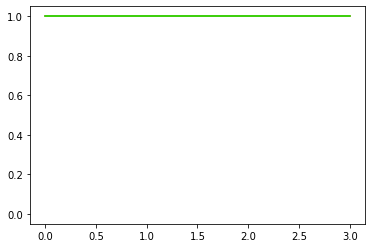

In [12]:
viz.showAttention(options)

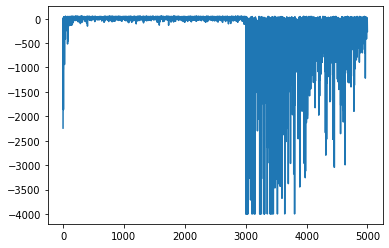

In [5]:
plt.plot(cumRewRec)
plt.show()

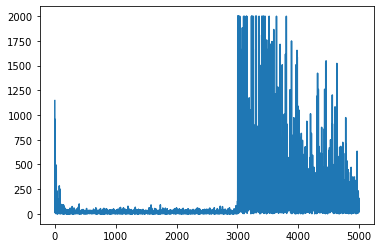

In [6]:
plt.plot(stepRec)
plt.show()

In [9]:
options[0].policy.internalPI.weights[0]

array([-1.37466011,  5.92352934, -3.9220698 , -0.62679942])

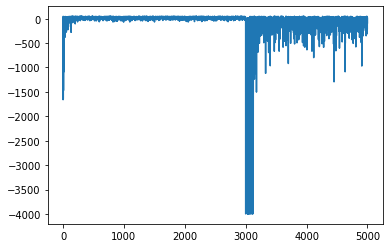

In [10]:
plt.plot(cumRewRec)
plt.show()

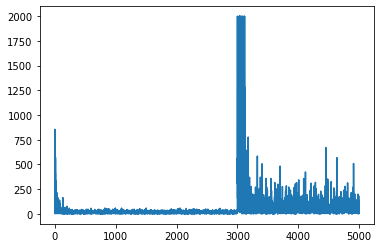

In [11]:
plt.plot(stepRec)
plt.show()

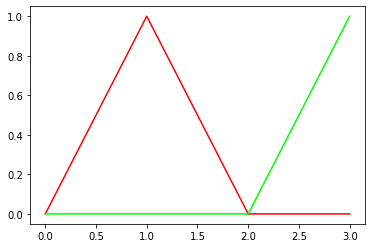

In [18]:
plt.plot([0,1,2,3], [0, 1, 1, 1], "w")
plt.plot([0,1,2,3], [0, 1, 0, 0], color =[1,0,0])
plt.plot([0,1,2,3], [0, 0, 0, 1], color =[0, 1, 0])
plt.show()